In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
from PIL import Image

In [2]:
# Path to Dataset
train_dir = 'mfi-data/train/'
test_dir = 'mfi-data/test/'

In [3]:
# Implement the Dataset class
class MFIDataset(Dataset):
    def __init__(self, folders_list, directory, label=1, mode='train', transform=None):
        self.folders_list = folders_list
        self.dir = directory
        self.mode = mode
        self.transform = transform
        self.label = label

    def __len__(self):
        return len(self.folders_list)

    def __getitem__(self, idx):
        nomask_img = Image.open(os.path.join(self.dir, self.folders_list[idx]+'/'+str(self.folders_list[idx])+'_nomask.jpg'))
        mask_img = Image.open(os.path.join(self.dir, self.folders_list[idx]+'/'+str(self.folders_list[idx])+'_mask.jpg'))		
        if self.transform:
            nomask_img = self.transform(nomask_img)
            mask_img = self.transform(mask_img)
        if self.mode == 'train':
            nomask_img = np.asarray(nomask_img)
            mask_img = np.asarray(mask_img)
            final = np.concatenate((nomask_img, mask_img), axis=0)
            return final, self.label
        else:
            nomask_img = np.asarray(nomask_img)
            mask_img = np.asarray(mask_img)
            final = np.concatenate((nomask_img, mask_img), axis=0)
            return final, self.folders_list[idx]

In [5]:
# Define the transforms, apply and preprocess the data
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224),
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class_1_data_folders = os.listdir(train_dir+'1/')
class_0_data_folders = os.listdir(train_dir+'0/')
class_1_dataset = MFIDataset(class_1_data_folders, train_dir+'1/', label=1, transform=data_transform)
class_0_dataset = MFIDataset(class_0_data_folders, train_dir+'0/', label=0, transform=data_transform)
train_dataset = ConcatDataset([class_1_dataset, class_0_dataset])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

class_1_data_folders = os.listdir(test_dir+'1/')
class_0_data_folders = os.listdir(test_dir+'0/')
class_1_dataset = MFIDataset(class_1_data_folders, test_dir+'1/', label=1, transform=data_transform)
class_0_dataset = MFIDataset(class_0_data_folders, test_dir+'0/', label=0, transform=data_transform)
test_dataset = ConcatDataset([class_1_dataset, class_0_dataset])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

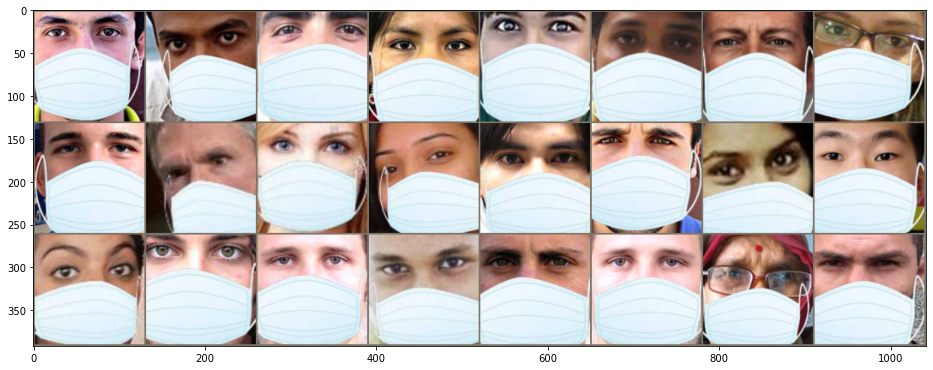

In [6]:
# Visualize the dataset
data_iter = iter(train_loader)
images, labels = data_iter.next() # sample one batch i.e, 32 samples
images = images[:, 3:6, :, :]
fig = plt.figure(figsize=(16, 24))
grid_imgs = torchvision.utils.make_grid(images[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
np_grid_imgs = np.transpose(np_grid_imgs, (1,2,0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
np_grid_imgs = std * np_grid_imgs + mean
np_grid_imgs = np.clip(np_grid_imgs, 0, 1)
plt.imshow(np_grid_imgs)

In [7]:
# Defining the device type
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
# Create a Siamese Network
class SiameseNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SiameseNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=5) 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5) 
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)  
        
        self.fc1 = nn.Linear(64*12*12, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, out_channels)
    
    def forward(self, x):
        # x shape - (batch_size, 6, 128, 128)
        x1 = x[:, :3, :, :] # no mask
        x2 = x[:, 3:6, :, :] # mask
        x1 = F.max_pool2d(F.relu(self.conv1(x1)), 2) # 128 -> 64
        x1 = F.max_pool2d(F.relu(self.conv2(x1)), 2) # 64 -> 30
        x1 = F.max_pool2d(F.relu(self.conv3(x1)), 2) # 30 -> 12
        x1 = x1.view(-1, 64*12*12)
                          
        x2 = F.max_pool2d(F.relu(self.conv1(x2)), 2)
        x2 = F.max_pool2d(F.relu(self.conv2(x2)), 2)
        x2 = F.max_pool2d(F.relu(self.conv3(x2)), 2)
        x2 = x2.view(-1, 64*12*12)
                          
        diff = torch.sub(x1, x2)
        x = F.relu(self.fc1(diff))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

In [9]:
# Check the model archtitecture
model = SiameseNet(3, 2)
model = model.to(device)
model

SiameseNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

In [12]:
import torch.optim as optimizer
# Hyperparameters
epochs = 10
lr = 1e-4

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optimizer.Adam(model.parameters(), lr=lr)

[Epoch 1/10] Iteration 1 -> Train Loss: 0.5347, Accuracy: 0.781
[Epoch 1/10] Iteration 2 -> Train Loss: 0.4753, Accuracy: 0.812
[Epoch 1/10] Iteration 3 -> Train Loss: 0.6129, Accuracy: 0.625
[Epoch 1/10] Iteration 4 -> Train Loss: 0.5234, Accuracy: 0.781
[Epoch 1/10] Iteration 5 -> Train Loss: 0.5228, Accuracy: 0.719
[Epoch 1/10] Iteration 6 -> Train Loss: 0.5976, Accuracy: 0.656
[Epoch 1/10] Iteration 7 -> Train Loss: 0.6024, Accuracy: 0.719
[Epoch 1/10] Iteration 8 -> Train Loss: 0.4293, Accuracy: 0.906
[Epoch 1/10] Iteration 9 -> Train Loss: 0.4961, Accuracy: 0.781
[Epoch 1/10] Iteration 10 -> Train Loss: 0.4640, Accuracy: 0.812
[Epoch 1/10] Iteration 11 -> Train Loss: 0.4898, Accuracy: 0.719
[Epoch 1/10] Iteration 12 -> Train Loss: 0.3500, Accuracy: 0.938
[Epoch 1/10] Iteration 13 -> Train Loss: 0.4771, Accuracy: 0.688
[Epoch 1/10] Iteration 14 -> Train Loss: 0.4449, Accuracy: 0.844
[Epoch 1/10] Iteration 15 -> Train Loss: 0.5040, Accuracy: 0.781
[Epoch 1/10] Iteration 16 -> Train

[Epoch 7/10] Iteration 129 -> Train Loss: 0.1555, Accuracy: 0.969
[Epoch 7/10] Iteration 130 -> Train Loss: 0.1380, Accuracy: 0.969
[Epoch 7/10] Iteration 131 -> Train Loss: 0.2155, Accuracy: 0.906
[Epoch 7/10] Iteration 132 -> Train Loss: 0.3000, Accuracy: 0.875
[Epoch 7/10] Iteration 133 -> Train Loss: 0.1044, Accuracy: 1.000
[Epoch 7/10] Iteration 134 -> Train Loss: 0.4675, Accuracy: 0.812
[Epoch 7/10] Iteration 135 -> Train Loss: 0.2602, Accuracy: 0.906
[Epoch 7/10] Iteration 136 -> Train Loss: 0.1563, Accuracy: 0.969
[Epoch 7/10] Iteration 137 -> Train Loss: 0.3679, Accuracy: 0.812
[Epoch 7/10] Iteration 138 -> Train Loss: 0.1977, Accuracy: 0.875
[Epoch 7/10] Iteration 139 -> Train Loss: 0.2566, Accuracy: 0.875
[Epoch 7/10] Iteration 140 -> Train Loss: 0.3195, Accuracy: 0.833
[Epoch 8/10] Iteration 141 -> Train Loss: 0.1390, Accuracy: 0.969
[Epoch 8/10] Iteration 142 -> Train Loss: 0.1607, Accuracy: 0.906
[Epoch 8/10] Iteration 143 -> Train Loss: 0.0738, Accuracy: 1.000
[Epoch 8/1

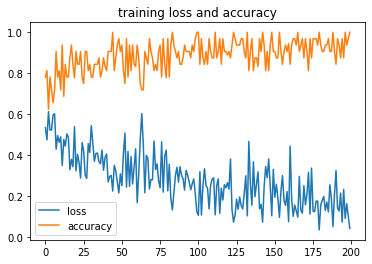

In [13]:
# Training
train_loss = 0
loss_list = []
acc_list = []
print_every = 1
counter = 1

for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (counter % print_every == 0):
            predicted_labels = torch.argmax(preds, dim=1)
            corrects = predicted_labels.eq(labels)
            accuracy = torch.mean(corrects.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'\
                  .format(epoch+1, epochs, counter, train_loss/print_every, accuracy))
            loss_list.append(train_loss/print_every)
            acc_list.append(accuracy)
            train_loss = 0
        
        counter += 1   

# Plot the training history
plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()

In [14]:
# Save weights
model_path = 'ckpt_resnet18_mfi.pth'
torch.save(model.state_dict(), model_path)

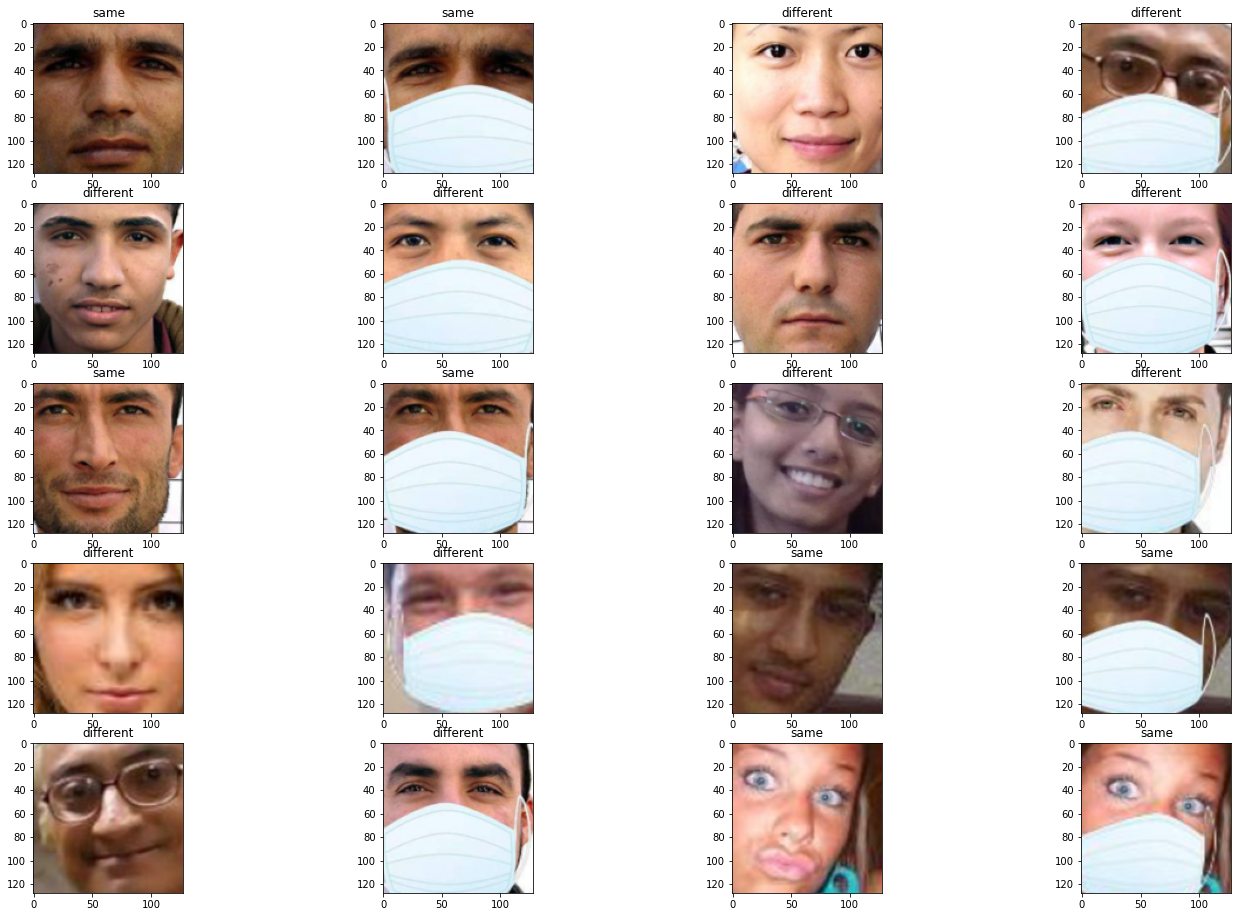

In [15]:
# Testing
def process_image(sample):
    sample1 = sample[:3,:, :].cpu().numpy()
    sample2 = sample[3:6, :, :].cpu().numpy()
    sample1 = np.transpose(sample1, (1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    sample1 = std * sample1 + mean
    sample1 = np.clip(sample1, 0, 1)
    
    sample2 = np.transpose(sample2, (1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    sample2 = std * sample2 + mean
    sample2 = np.clip(sample2, 0, 1)
    
    return sample1, sample2
    
samples, _ = iter(test_loader).next()
samples = samples.to(device)
output = model(samples[:10])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'different', 1:'same'}
f, axarr = plt.subplots(5, 4, figsize=(24, 16))
counter = 0
for i in range(5):
    for j in range(0, 4, 2):
        sample = samples[counter]
        nomask_img, mask_img = process_image(sample)
        axarr[i,j].imshow(nomask_img)
        axarr[i,j].set_title(ad[pred[counter]])
        axarr[i,j+1].imshow(mask_img)
        axarr[i,j+1].set_title(ad[pred[counter]])
        counter += 1
plt.show()